### Fashion-Clip image 

### Create Embedding with fashion-clip

2023-12-06 15:58:48.564611: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 15:58:48.565724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 15:58:48.584648: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 15:58:48.585125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 15:58:49.079722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

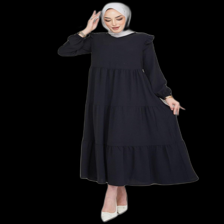

In [4]:
from PIL import Image
from rembg import remove
import requests
from transformers import CLIPProcessor, CLIPModel

input_path = 'tests/data/test_image.jpg'
output_path = 'tests/data/test_image_rem.jpg'

input = Image.open(input_path)
output = remove(input)
output = output.convert("RGB")


output.save(output_path)

image = Image.open("tests/data/test_image_rem.jpg")


model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
processor = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")


inputs = processor(text=["a photo of a black dress", "a photo of a black shoe"],
                   images=image, return_tensors="pt", padding=True)
pixel_values = inputs['pixel_values']
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  
# print(probs)


image.resize((224, 224))

### Analysis of fashion-clip onnx model

In [10]:
import onnxruntime as ort
from transformers import AutoTokenizer

# Load the ONNX model
sess = ort.InferenceSession("models/image/model.onnx")

In [11]:
# Get the input names and shapes
input_meta = sess.get_inputs()
for meta in input_meta:
    print(f"Name: {meta.name}, Shape: {meta.shape}")

Name: input_ids, Shape: ['text_batch_size', 'sequence_length']
Name: pixel_values, Shape: ['image_batch_size', 'num_channels', 'height', 'width']
Name: attention_mask, Shape: ['text_batch_size', 'sequence_length']


### try to create a torch.Size([1, 3, 224, 224]) from image bytes

In [2]:
from PIL import Image
import torch
from torchvision import transforms

def preprocess(image_path):
    # Open the image file
    img = Image.open(image_path).convert('RGB')

    # Define the transformation
    preprocess = transforms.Compose([
        transforms.Resize(224),  # Resize the short side of the image to 224
        transforms.CenterCrop(224),  # Crop a 224x224 square from the center
        transforms.ToTensor(),  # Convert the image to a tensor with values between 0 and 1
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])

    # Apply the transformation and add an extra dimension for the batch size
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)

    return batch_t

# Test the function
image_tensor = preprocess("tests/data/test_image.jpg")
print(image_tensor.shape)  # Should print: torch.Size([1, 3, 224, 224])

torch.Size([1, 3, 224, 224])


In [18]:
assert torch.all(torch.eq(tensor, pixel_values)), "The tensors are not equal"

AssertionError: The tensors are not equal

In [5]:
if not torch.allclose(image_tensor, pixel_values, atol=1e-6):
    diff = torch.abs(image_tensor - pixel_values)
    print("Differences:")
    print(diff)
    print("Positions of differences:")
    print(torch.where(torch.abs(image_tensor - pixel_values) > 1e-6))
else:
    print("The tensors are approximately equal within the tolerance")

Differences:
tensor([[[[4.0412, 4.0412, 4.0412,  ..., 4.0412, 4.0412, 4.0412],
          [4.0412, 4.0412, 4.0412,  ..., 4.0412, 4.0412, 4.0412],
          [4.0412, 4.0412, 4.0412,  ..., 4.0412, 4.0412, 4.0412],
          ...,
          [4.0412, 4.0412, 4.0412,  ..., 4.0412, 4.0412, 4.0412],
          [4.0412, 4.0412, 4.0412,  ..., 4.0412, 4.0412, 4.0412],
          [4.0412, 4.0412, 4.0412,  ..., 4.0412, 4.0412, 4.0412]],

         [[4.1807, 4.1807, 4.1807,  ..., 4.1807, 4.1807, 4.1807],
          [4.1807, 4.1807, 4.1807,  ..., 4.1807, 4.1807, 4.1807],
          [4.1807, 4.1807, 4.1807,  ..., 4.1807, 4.1807, 4.1807],
          ...,
          [4.1807, 4.1807, 4.1807,  ..., 4.1807, 4.1807, 4.1807],
          [4.1807, 4.1807, 4.1807,  ..., 4.1807, 4.1807, 4.1807],
          [4.1807, 4.1807, 4.1807,  ..., 4.1807, 4.1807, 4.1807]],

         [[4.1202, 4.1202, 4.1202,  ..., 4.1202, 4.1202, 4.1202],
          [4.1202, 4.1202, 4.1202,  ..., 4.1202, 4.1202, 4.1202],
          [4.1202, 4.1202, 4.

In [6]:
# Calculate the element-wise approximate equality
close_elements = torch.isclose(image_tensor, pixel_values, atol=1e-6)

# Count the number of matching and different values
num_matches = torch.sum(close_elements)
num_differences = torch.numel(image_tensor) - num_matches

print(f"Number of matching values: {num_matches}")
print(f"Number of different values: {num_differences}")

Number of matching values: 0
Number of different values: 150528
